In diesem Notebook werden die 4 annotierten Videos eingelesen und die balancierte Accuracy berechnet. Außerdem weitere Messungen von Gesichtserkennung und eye-contact-cnn. 

In [2]:
from eye_contact_frames import eye_contact_frames 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Funktionen

In [3]:
def merge_annotations_real(number_annotation: int, total_frames:int, extra_txt_names:str = ""):
    """Liest die Annotations ein und verbindet sie mit den Ergebnissen des Modells

    Args:
        number_annotation (int): Die Nummer des Videos (zwischen 2 und 5)
        total_frames (int): Gesamtzahl der annotierten Frames
        extra_txt_names (str, optional): Falls die txt-Datei mit den Ergebnissen des Modells einen anderen Namen hat, kann dies hier angehängt werden. Defaults to "".

    Returns:
        pd.DataFrame: Der über Frames verbundene DataFrame mit annotierten Daten und den Ergebnissen des Modells. 
    """
    df_annotated = pd.Series(eye_contact_frames(f"annotations/annotations_{number_annotation}.xml", total_frames), name = "annotated")
    df = pd.read_csv(f"video_annot{number_annotation}{extra_txt_names}.txt", names = ["frame", "score"])
    print(df_annotated.value_counts())
    merged = pd.merge(df, df_annotated, left_on = "frame", right_index=True)
    return merged

In [1]:
def density(merged:pd.DataFrame):
    """Gibt die relative Anzahl der Frames an, in denen das Modell ein Gesicht gefunden hat. 

    Args:
        merged (pd.DataFrame): DataFrame, mit annotierten Daten und den Scores aus dem Modell

    Returns:
        str: Gibt in Prozent aus, auf wie vielen Frames ein Gesicht gefunden wird.
    """
    print(merged.shape[0], merged.frame.max())
    return f"Auf {merged.shape[0]/ merged.frame.max()*100 :.2f}% der Frames wurde ein Gesicht gefunden."


In [5]:
def view(threshold:float, annotations:pd.Series, real:pd.Series):
    """Plottet für einen bestimmten Threshold die Confusionmatrix

    Args:
        threshold (float): Der Wert, ab dem die Scores aus eye-contact-cnn zu einem erkannten Blick aufgerundet werden sollen.v 
        annotations (pd.Series): Die binären Werte, die manuell annotiert wurden
        real (pd.Series): Die Scores von eye-contact-cnn
    """
    real_rounded = [x>threshold for x in real]
    print("%.2f" %threshold,"%.3f" %accuracy_score(annotations, real_rounded), "%.3f"%balanced_accuracy_score(annotations, real_rounded))
    ConfusionMatrixDisplay(confusion_matrix(annotations, real_rounded)).plot()
    plt.show()

In [6]:
def get_df_accs(merged:pd.DataFrame):
    """Berechnet für einen neuen DataFrame für unterschiedliche Thresholds die balanced Accuracy und die Accuracy

    Args:
        merged (pd.DataFrame): Der DataFrame mit den Instanzen, die für einen bestimmten Frame einen Score von eye-contact-cnn und den annotierten Wert enthält. 

    Returns:
        pd.DataFrame: neuer DataFrame, welcher für Thresholds die Accuracy und balanced Accuracy innerhalb eines Videos enthält
    """
    accs = []
    baccs = []
    for threshold in np.arange(0,1,.005):
        accs.append(accuracy_score(merged.annotated, [int(x>threshold) for x in merged.score]))
        baccs.append(balanced_accuracy_score(merged.annotated, [int(x>threshold) for x in merged.score]))

    df = pd.DataFrame()
    df["threshold"] = np.arange(0,1,.005)
    df["accuracy"] = accs
    df["balanced_acc"] = baccs
    return df

In [7]:
def max_threshold(accs):
    """Gibt den bestmöglichen Threshold bezogen auf die balanced Accuracy aus. 

    Args:
        accs (pd.DataFrame): DataFrame wie von get_df_accs generiert

    Returns:
        set: der Threshold an der Stelle der höchsten bestimmten balanced Accuracy 
    """
    thresholds = accs[accs.balanced_acc == accs.balanced_acc.max()].threshold
    if len(thresholds) == 1:
        return thresholds
    else:
        # if there is more than one best solution, look at accuracy.
        # if there is still more than one, take the first. 
        return set(thresholds).union(accs[accs.accuracy == accs.accuracy.max()].threshold).pop()

# Video 2 - Evgeny Lyon

Die ersten 21000 Frames des Videos werden eingelesen, mit Cascade-Classifier analysiert und mit den annotierten Ergebnissen verglichen. Andere Videos verlaufen analog.

In [8]:
merged2 = merge_annotations_real(2, 21000, "_output")
merged2

annotated
0.0    18371
1.0     2629
Name: count, dtype: int64


,frame,score,annotated
0,181,0.712508,0.0
1,361,0.740293,0.0
2,658,0.242010,0.0
3,710,0.810450,0.0
4,710,0.617997,0.0
...,...,...,...
1512,20452,0.002588,0.0
1513,20477,0.000025,0.0
1514,20527,0.023533,0.0
1515,20744,0.763126,0.0


In [9]:
# Anteil der Frames, in denen mehr als ein Gesicht gefunden wird.
1-len(merged2.frame.unique())/1517

0.01713909030982197

In [10]:
# Anteil in die Kamera schauen zu Gesamtzahl von Frames
merged2.value_counts("annotated")
204/1517, 2629/21000

(0.13447593935398813, 0.12519047619047619)

In [42]:
density(merged2)

# Anzahl gefundener Gesichter, Anzahl annotierter Gesichter

1517 20745


'Auf 7.31% der Frames wurde ein Gesicht gefunden.'

In [12]:
accs2 = get_df_accs(merged2)
accs2.balanced_acc#[accs2.balanced_acc >.5]

0      0.500000
1      0.486651
2      0.477872
3      0.467736
4      0.468331
         ...   
195    0.500000
196    0.500000
197    0.500000
198    0.500000
199    0.500000
Name: balanced_acc, Length: 200, dtype: float64

0.20 0.200 0.341


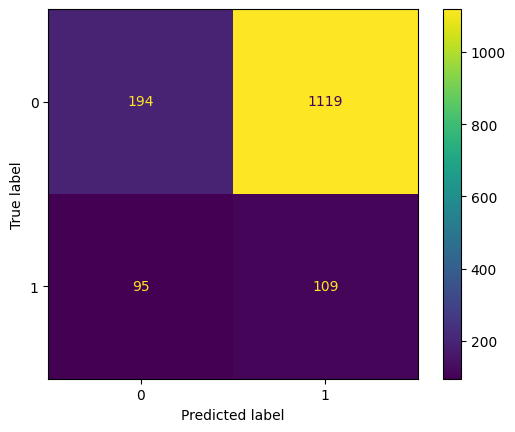

0.25 0.243 0.348


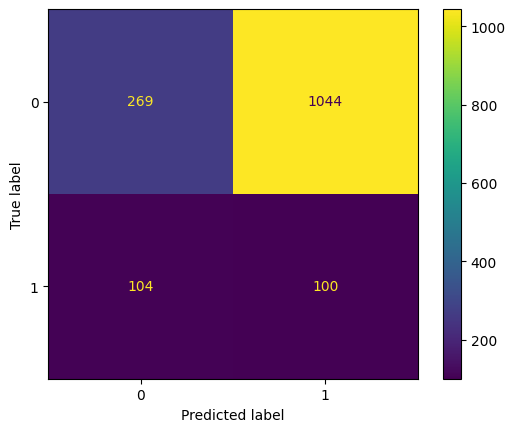

0.30 0.297 0.345


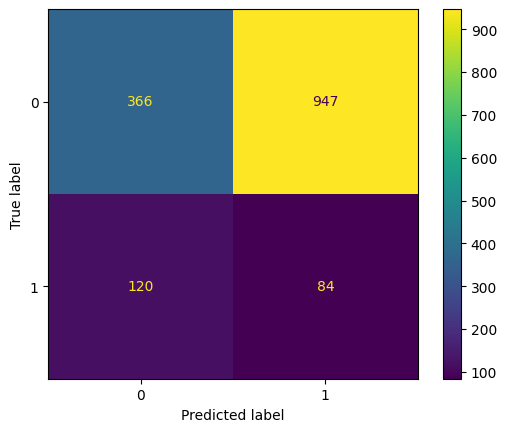

0.35 0.365 0.355


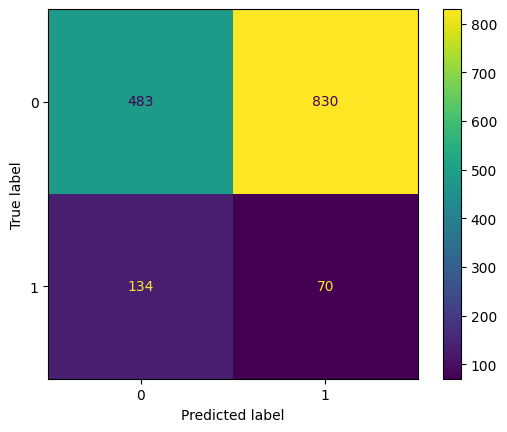

0.40 0.471 0.386


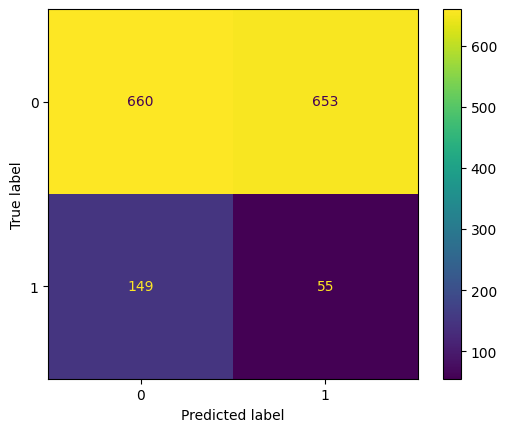

0.45 0.588 0.418


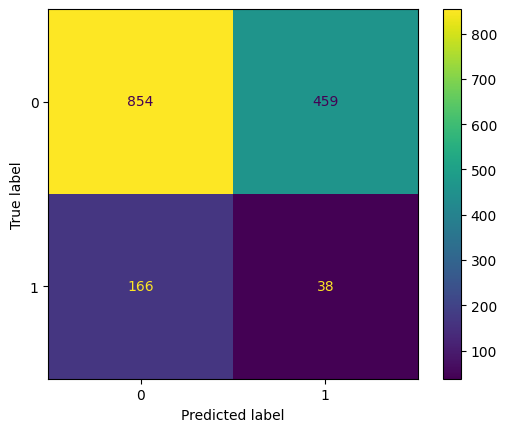

0.50 0.682 0.439


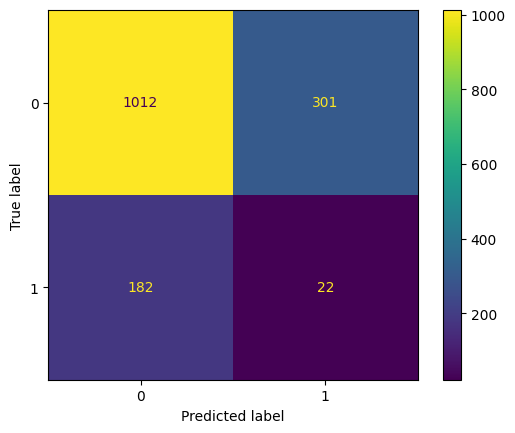

0.55 0.765 0.467


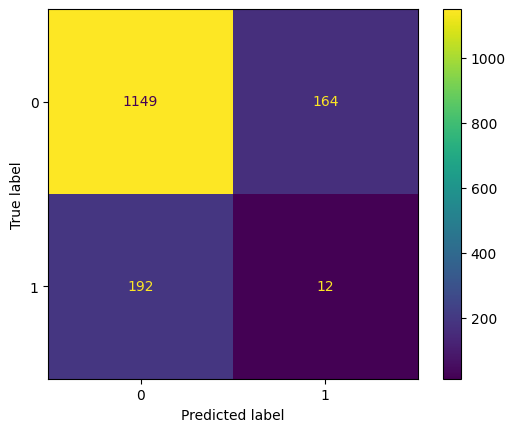

0.60 0.813 0.476


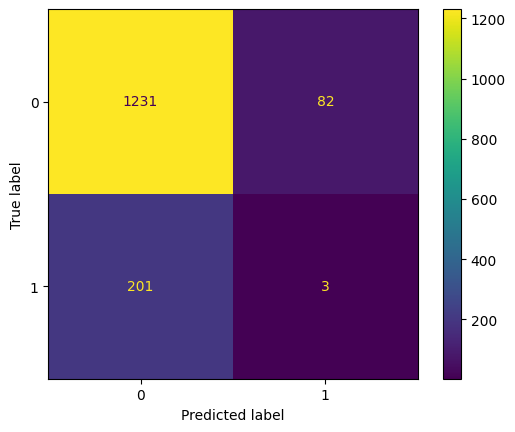

0.65 0.837 0.483


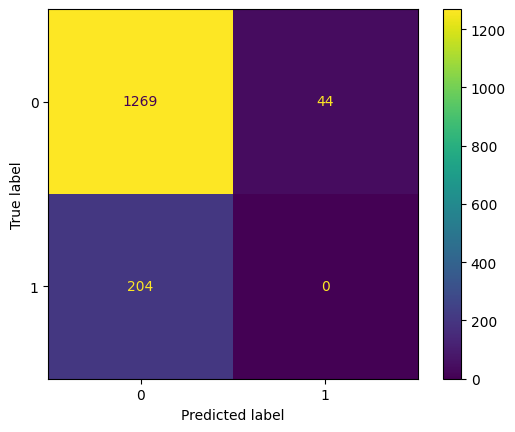

0.70 0.850 0.491


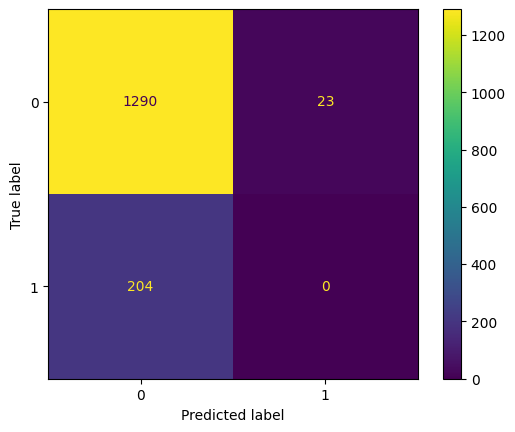

0.75 0.856 0.494


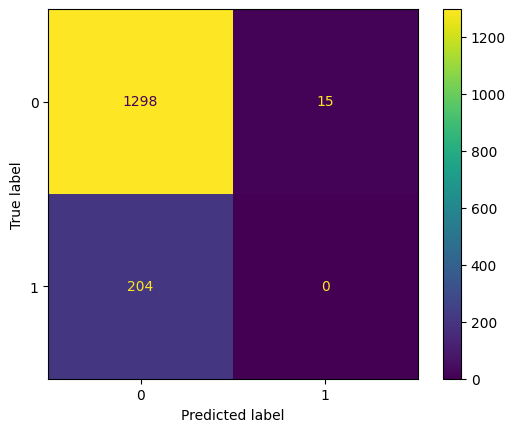

0.80 0.859 0.496


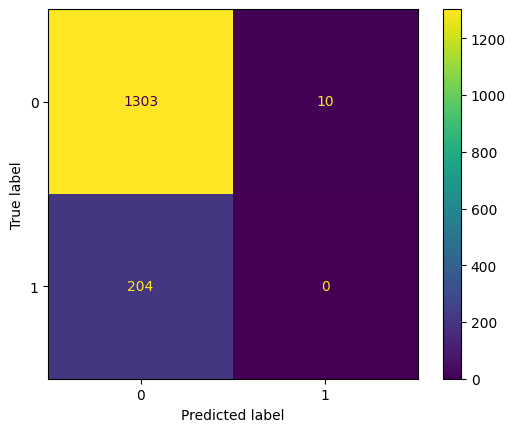

0.85 0.863 0.498


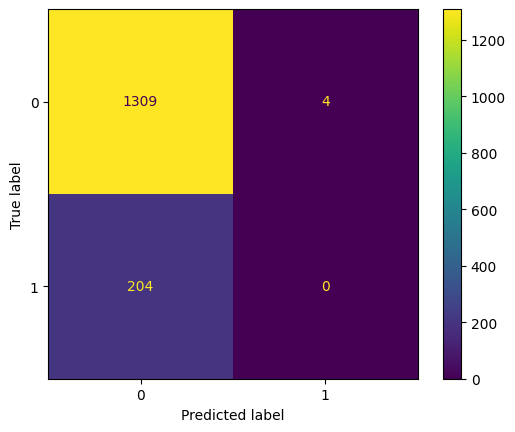

0.90 0.866 0.500


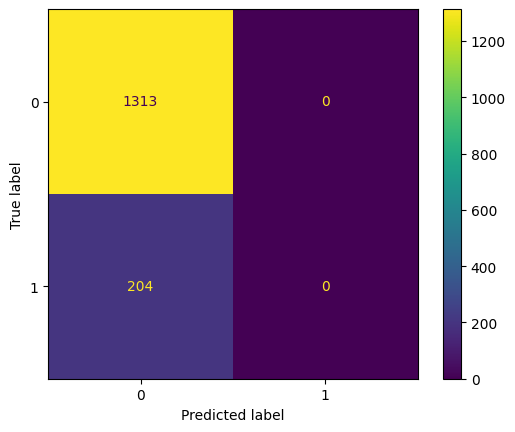

0.95 0.866 0.500


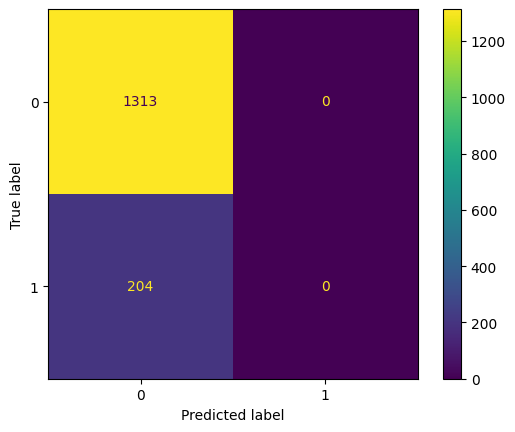

In [13]:
for i in np.arange(.2,1,.05):
    view(i, merged2.annotated, merged2.score)


In [14]:
print(classification_report(merged2.annotated, [x>.2 for x in merged2.score]))   

              precision    recall  f1-score   support

         0.0       0.67      0.15      0.24      1313
         1.0       0.09      0.53      0.15       204

    accuracy                           0.20      1517
   macro avg       0.38      0.34      0.20      1517
weighted avg       0.59      0.20      0.23      1517



# Video 3

## cropped mediapipe

In [15]:
merged_mediapipe = merge_annotations_real(3, 17000, "_crop_output_mediapipe")
merged_mediapipe[merged_mediapipe.frame < 4257]#.loc[5:]

annotated
0.0    13960
1.0     3040
Name: count, dtype: int64


,frame,score,annotated
0,42,0.233458,1.0
1,46,0.378733,1.0
2,48,0.477610,1.0
3,49,0.507607,1.0
4,50,0.391993,1.0
...,...,...,...
624,4123,0.052289,1.0
625,4124,0.080456,1.0
626,4138,0.032838,0.0
627,4140,0.074721,0.0


In [16]:
merged_mediapipe

,frame,score,annotated
0,42,0.233458,1.0
1,46,0.378733,1.0
2,48,0.477610,1.0
3,49,0.507607,1.0
4,50,0.391993,1.0
...,...,...,...
654,6982,0.019445,1.0
655,7265,0.018972,1.0
656,7371,0.021798,0.0
657,7738,0.004991,0.0


In [17]:
print(1-len(merged_mediapipe.frame.unique())/659)
print(merged_mediapipe.value_counts("annotated"))
537/659, 3040/17000

0.0
annotated
1.0    537
0.0    122
Name: count, dtype: int64


(0.8148710166919575, 0.17882352941176471)

In [18]:
density(merged_mediapipe)

659 12545


'Auf 5.25% der Frames wurde ein Gesicht gefunden.'

In [41]:
accs3_mp = get_df_accs(merged_mediapipe).set_index("threshold")
accs3_mp[accs3_mp.balanced_acc >.71]

,accuracy,balanced_acc
threshold,,
0.060,0.871017,0.711817
0.065,0.869499,0.714053
0.070,0.867982,0.716290
0.075,0.866464,0.718526
0.080,0.861912,0.715733
0.085,0.860395,0.714801
0.090,0.857360,0.719274
0.095,0.854325,0.717412
0.100,0.849772,0.714618


0.10 0.850 0.715


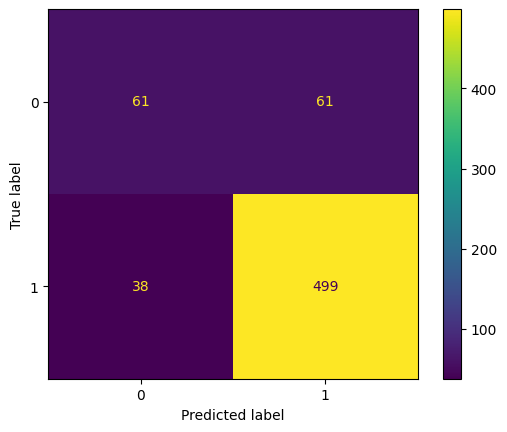

In [20]:

view(.1, merged_mediapipe.annotated, merged_mediapipe.score)

In [21]:
print(classification_report(merged_mediapipe.annotated, [x>.2 for x in merged_mediapipe.score]))

              precision    recall  f1-score   support

         0.0       0.34      0.59      0.43       122
         1.0       0.89      0.74      0.81       537

    accuracy                           0.71       659
   macro avg       0.61      0.66      0.62       659
weighted avg       0.79      0.71      0.74       659



## cascade

In [22]:
merged3 = merge_annotations_real(3, 17000, "_output")
merged3.set_index("frame")#.loc[526:540]

annotated
0.0    13960
1.0     3040
Name: count, dtype: int64


,score,annotated
frame,,
2,0.853856,1.0
5,0.852196,1.0
6,0.840121,1.0
7,0.855735,1.0
8,0.900792,1.0
...,...,...
4252,0.386503,0.0
4253,0.708105,0.0
4253,0.314906,0.0


In [23]:
print(1-len(merged3.frame.unique())/1101)
print(merged3.value_counts("annotated"))
531/1101, 3040/17000

0.1489554950045413
annotated
0.0    570
1.0    531
Name: count, dtype: int64


(0.4822888283378747, 0.17882352941176471)

In [24]:
density(merged3)

1101 4256


'Auf 25.87% der Frames wurde ein Gesicht gefunden.'

In [25]:
accs3 = get_df_accs(merged3)
accs3.set_index("threshold", inplace=True)
accs3[accs3.balanced_acc > 0.509]

,accuracy,balanced_acc
threshold,,
0.84,0.524977,0.509659


### confusion matrices

0.85 0.522 0.507


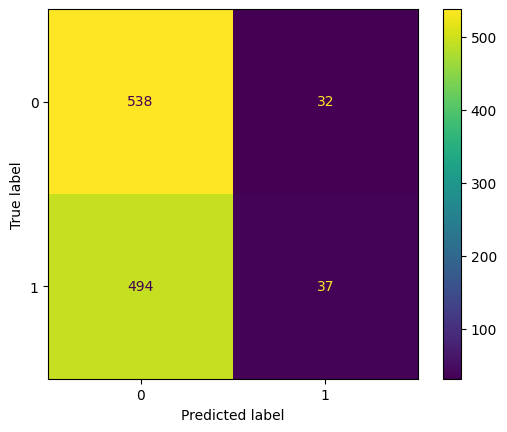

In [26]:
# for i in np.arange(.2,1,.05):
#     view(i, merged3.annotated, merged3.acc)

view(.85, merged3.annotated, merged3.score)

### classification report

In [27]:
print(classification_report(merged3.annotated, [x>.85 for x in merged3.score]))

              precision    recall  f1-score   support

         0.0       0.52      0.94      0.67       570
         1.0       0.54      0.07      0.12       531

    accuracy                           0.52      1101
   macro avg       0.53      0.51      0.40      1101
weighted avg       0.53      0.52      0.41      1101



# Video 4 - Vera

In [28]:
merged4 = merge_annotations_real(4, 20400, "_output")
merged4

annotated
0.0    12961
1.0     7439
Name: count, dtype: int64


,frame,score,annotated
0,1,0.968300,0.0
1,2,0.969990,0.0
2,3,0.970669,0.0
3,4,0.955709,0.0
4,5,0.955709,0.0
...,...,...,...
7578,20386,0.062766,0.0
7579,20389,0.214603,0.0
7580,20393,0.010471,0.0
7581,20396,0.012018,0.0


In [29]:
density(merged4)

7583 20397


'Auf 37.18% der Frames wurde ein Gesicht gefunden.'

In [30]:
print(1-len(merged4.frame.unique())/7583)
print(merged4.value_counts("annotated"))
5689/7583, 7439/20400

0.13675326387973097
annotated
1.0    5689
0.0    1894
Name: count, dtype: int64


(0.7502307793749176, 0.36465686274509806)

In [31]:
accs4 = get_df_accs(merged4)
accs4[accs4.balanced_acc >.6369]

,threshold,accuracy,balanced_acc
139,0.695,0.761836,0.636994
140,0.700,0.761044,0.636995
141,0.705,0.759858,0.636908
143,0.715,0.758011,0.637086
152,0.760,0.746802,0.637188
153,0.765,0.744824,0.637103


0.90 0.576 0.560


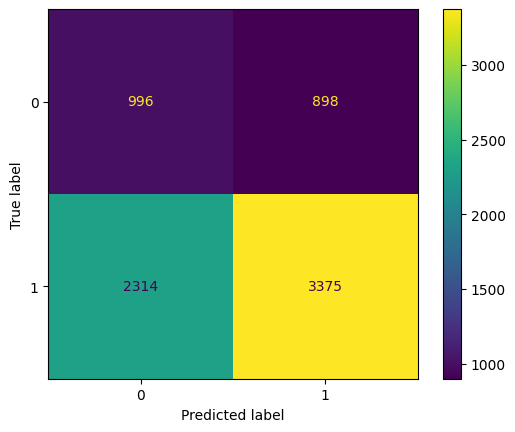

              precision    recall  f1-score   support

         0.0       0.49      0.42      0.45      1894
         1.0       0.82      0.86      0.84      5689

    accuracy                           0.75      7583
   macro avg       0.65      0.64      0.64      7583
weighted avg       0.73      0.75      0.74      7583



In [32]:
view(.9, merged4.annotated, merged4.score)
print(classification_report(merged4.annotated, [x>.76 for x in merged4.score]))

# Video 5 - Vera

In [33]:
merged5 = merge_annotations_real(5, 6378, "_output_cascade")
merged5#[merged5.score > .5]

annotated
0.0    4453
1.0    1925
Name: count, dtype: int64


,frame,score,annotated
0,2,0.261932,1.0
1,12,0.234186,1.0
2,13,0.266573,1.0
3,15,0.206249,1.0
4,16,0.213829,1.0
...,...,...,...
3652,6363,0.096805,1.0
3653,6364,0.333295,1.0
3654,6365,0.226451,1.0
3655,6367,0.097199,1.0


In [34]:
# auf etwa der Hälfte der Frames wurde ein Gesicht gefunden.
density(merged5)

3657 6370


'Auf 57.41% der Frames wurde ein Gesicht gefunden.'

In [35]:
print(1-len(merged5.frame.unique())/3657)
print(merged5.value_counts("annotated"))
1229/3657, 1925/6378

0.1375444353295051
annotated
0.0    2428
1.0    1229
Name: count, dtype: int64


(0.3360678151490293, 0.301818751959862)

In [38]:
accs5 = get_df_accs(merged5)
accs5[accs5.balanced_acc >0.545]


,threshold,accuracy,balanced_acc
151,0.755,0.680886,0.545716
152,0.760,0.680886,0.545113
153,0.765,0.681706,0.545329
154,0.770,0.682527,0.545545
155,0.775,0.682800,0.545349
156,0.780,0.684167,0.546178
158,0.790,0.684988,0.545791


0.20 0.404 0.450


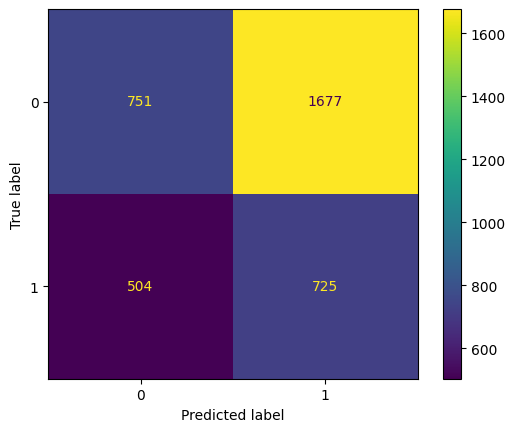

0.25 0.415 0.433


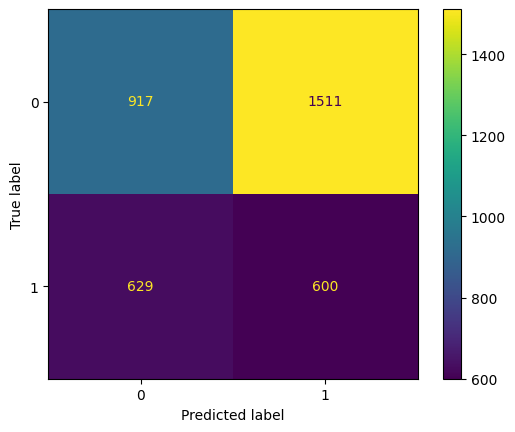

0.30 0.431 0.430


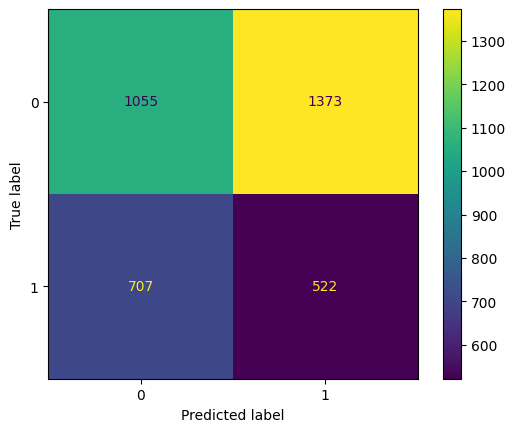

0.35 0.463 0.439


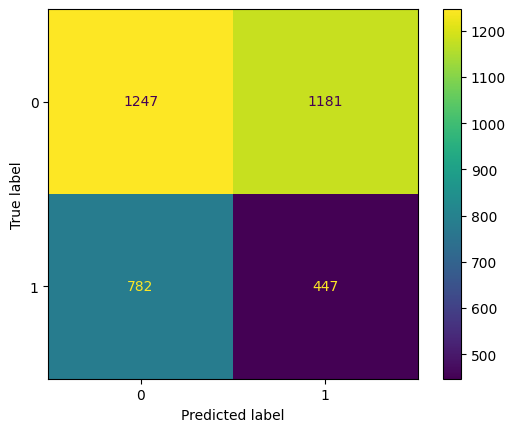

0.40 0.504 0.462


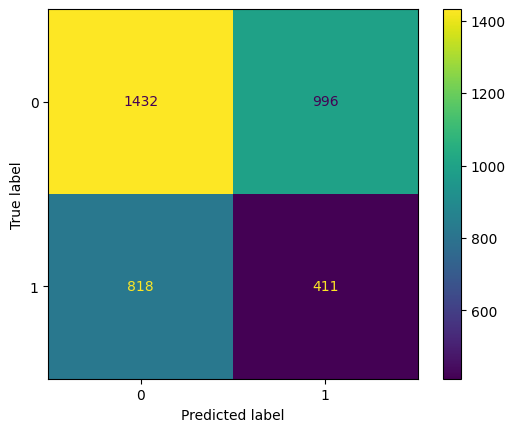

0.45 0.540 0.481


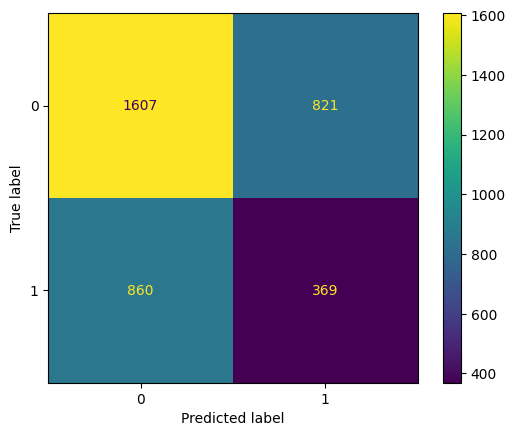

0.50 0.566 0.494


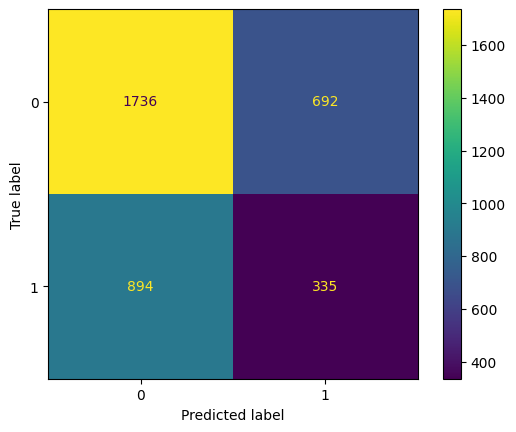

0.55 0.598 0.510


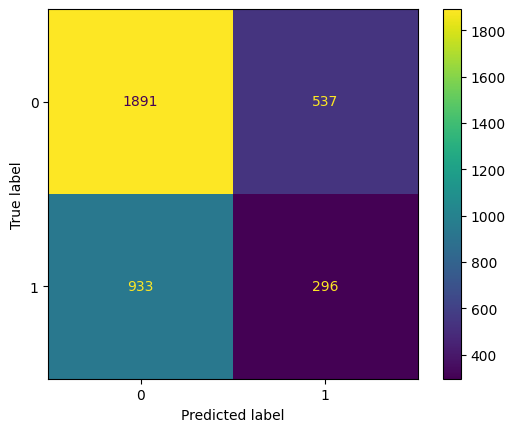

0.60 0.630 0.526


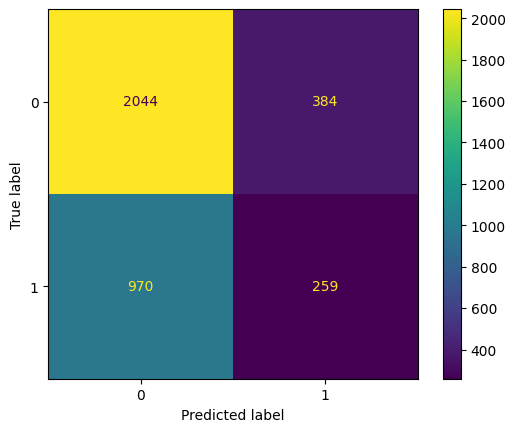

0.65 0.651 0.535


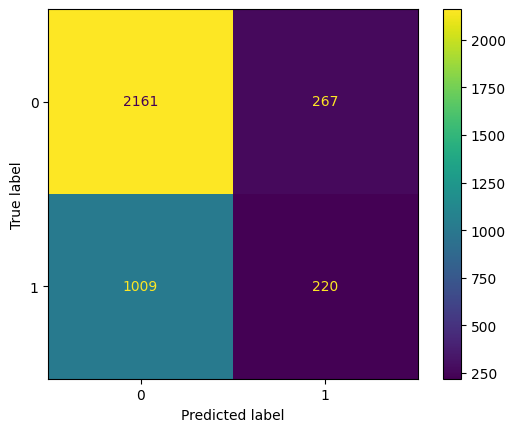

0.70 0.665 0.539


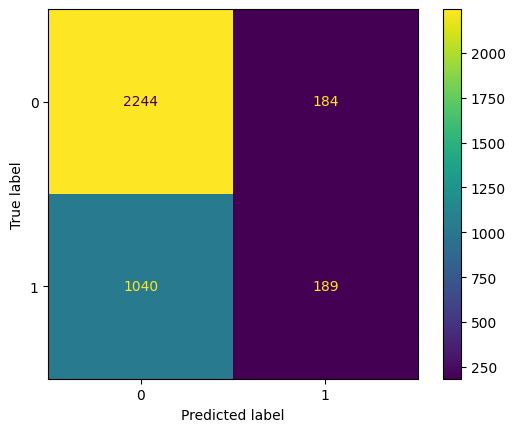

0.75 0.679 0.545


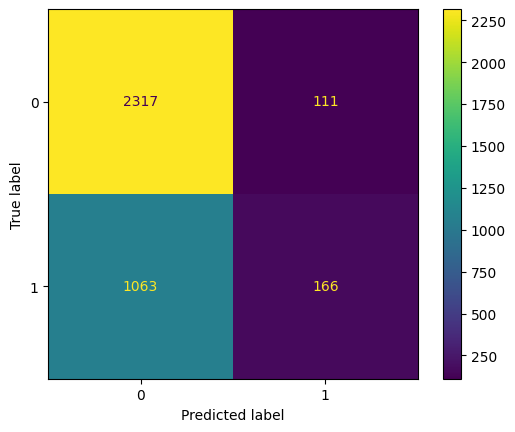

0.80 0.684 0.544


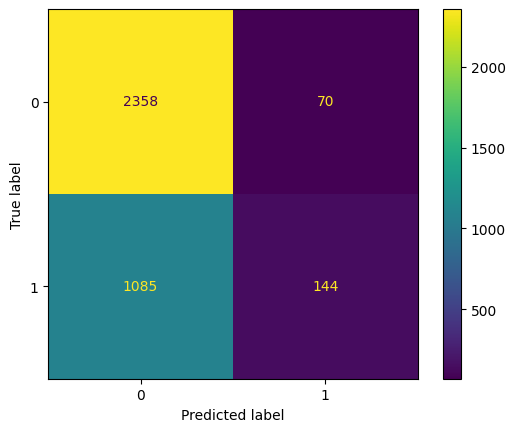

0.85 0.684 0.541


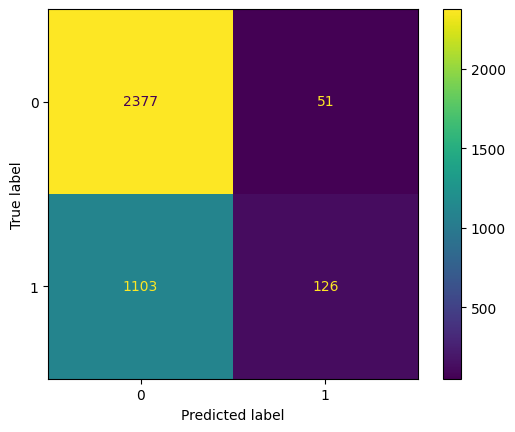

0.90 0.678 0.526


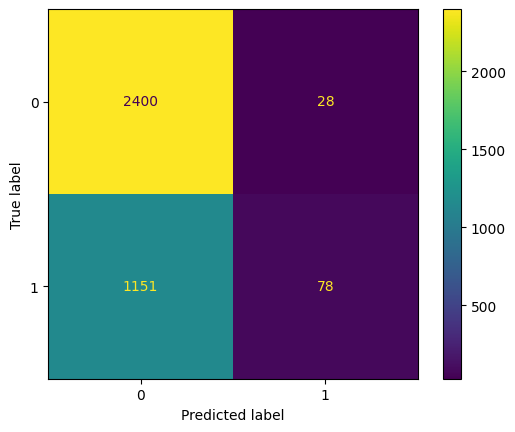

0.95 0.669 0.508


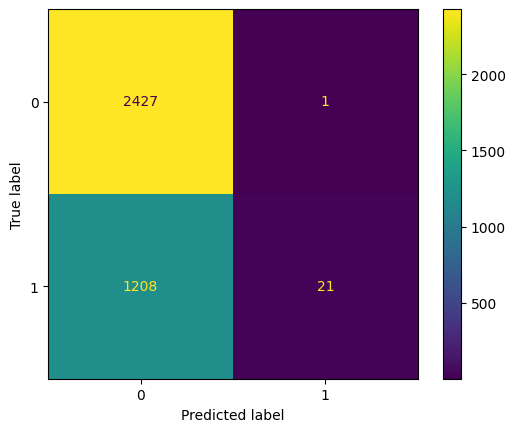

In [36]:
for i in np.arange(.2,1,.05):
    view(i, merged5.annotated, merged5.score)


In [37]:
print(classification_report(merged5.annotated, [x>.2 for x in merged5.score]))

              precision    recall  f1-score   support

         0.0       0.60      0.31      0.41      2428
         1.0       0.30      0.59      0.40      1229

    accuracy                           0.40      3657
   macro avg       0.45      0.45      0.40      3657
weighted avg       0.50      0.40      0.40      3657



# Vergleich 
- Vera (4, 5)
- Evgeny (2)

In [38]:
def auswertung(accs, video_number):
    return ("The maximum balanced accuracy of Video %d is %.4f at the threshold %.2f." % (video_number, accs.balanced_acc.max(), max_threshold(accs)))


In [39]:
auswertung(accs2, 2), auswertung(accs4, 4), auswertung(accs5, 5)


C:\Users\jojom\AppData\Local\Temp\ipykernel_13536\4117290568.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return ("The maximum balanced accuracy of Video %d is %.4f at the threshold %.2f." % (video_number, accs.balanced_acc.max(), max_threshold(accs)))


('The maximum balanced accuracy of Video 2 is 0.5000 at the threshold 0.00.',
 'The maximum balanced accuracy of Video 4 is 0.6372 at the threshold 0.76.',
 'The maximum balanced accuracy of Video 5 is 0.5462 at the threshold 0.78.')

# Test

In [40]:
merged3_smaller = merged3[merged3.frame < 12546].set_index("frame")
merged3_smaller = merged3_smaller.groupby(["frame"]).agg("max")

In [41]:
merged_mediapipe_smaller =  merged_mediapipe[merged_mediapipe.frame < 4257].set_index("frame")
merged_mediapipe_smaller.index.astype("int")
merged_mediapipe_smaller

,score,annotated
frame,,
42,0.233458,1.0
46,0.378733,1.0
48,0.477610,1.0
49,0.507607,1.0
50,0.391993,1.0
...,...,...
4123,0.052289,1.0
4124,0.080456,1.0
4138,0.032838,0.0


In [42]:
compare_3 = pd.DataFrame(index=range(4257))
compare_3["mediapipe_score"] = merged_mediapipe_smaller.score
compare_3["cascade_score"] = merged3_smaller.score
compare_3["annotated"] = pd.Series(eye_contact_frames(f"annotations/annotations_{3}.xml", 17000), name = "annotated")
compare_3.dropna(subset=["mediapipe_score", "cascade_score"], how='all')

,mediapipe_score,cascade_score,annotated
2,NaN,0.853856,1.0
5,NaN,0.852196,1.0
6,NaN,0.840121,1.0
7,NaN,0.855735,1.0
8,NaN,0.900792,1.0
...,...,...,...
4251,NaN,0.798746,0.0
4252,NaN,0.386503,0.0
4253,NaN,0.708105,0.0
4255,NaN,0.596999,0.0


In [43]:
compare_3.dropna(axis=0).sample(10).sort_index()

,mediapipe_score,cascade_score,annotated
506,0.398036,0.908474,0.0
591,0.411830,0.663432,1.0
687,0.507495,0.614344,1.0
1541,0.008679,0.439952,0.0
3509,0.398193,0.685951,1.0
3523,0.565706,0.651462,1.0
3741,0.164098,0.364473,1.0
3771,0.292084,0.505062,1.0
3826,0.253539,0.467533,1.0
3880,0.137257,0.419568,1.0


In [44]:
accs2

,threshold,accuracy,balanced_acc
0,0.000,0.134476,0.500000
1,0.005,0.136454,0.486651
2,0.010,0.146341,0.477872
3,0.015,0.150297,0.467736
4,0.020,0.154911,0.468331
...,...,...,...
195,0.975,0.865524,0.500000
196,0.980,0.865524,0.500000
197,0.985,0.865524,0.500000
198,0.990,0.865524,0.500000


In [45]:
cascade = pd.DataFrame()
cascade["Video 2 accuracy"] = accs2.accuracy
cascade["Video 2 balanced accuracy"] = accs2.balanced_acc
cascade["Video 3 accuracy"] = accs3.accuracy
cascade["Video 3 balanced accuracy"] = accs3.balanced_acc
cascade["Video 4 accuracy"] = accs4.accuracy
cascade["Video 4 balanced accuracy"] = accs4.balanced_acc
cascade["Video 5 accuracy"] = accs5.accuracy
cascade["Video 5 balanced accuracy"] = accs5.balanced_acc
cascade.index = accs5.threshold
cascade

,Video 2 accuracy,Video 2 balanced accuracy,Video 3 accuracy,Video 3 balanced accuracy,Video 4 accuracy,Video 4 balanced accuracy,Video 5 accuracy,Video 5 balanced accuracy
threshold,,,,,,,,
0.000,0.134476,0.500000,0.482289,0.5,0.750231,0.500000,0.336068,0.500000
0.005,0.136454,0.486651,NaN,NaN,0.752077,0.503872,0.340716,0.503501
0.010,0.146341,0.477872,NaN,NaN,0.753791,0.508008,0.347006,0.507835
0.015,0.150297,0.467736,NaN,NaN,0.755374,0.511704,0.353842,0.512180
0.020,0.154911,0.468331,NaN,NaN,0.756033,0.514433,0.357670,0.514661
...,...,...,...,...,...,...,...,...
0.975,0.865524,0.500000,NaN,NaN,0.270078,0.451899,0.665299,0.502034
0.980,0.865524,0.500000,NaN,NaN,0.251352,0.452626,0.664753,0.501221
0.985,0.865524,0.500000,NaN,NaN,0.239219,0.459862,0.664479,0.500814


Vergleich MEDIAPIPE; cascade mit video 3

In [53]:
np.mean(merged_mediapipe[merged_mediapipe.annotated == 1].score), np.mean(merged_mediapipe[merged_mediapipe.annotated == 0].score)

(0.3350576275605214, 0.22454604918032786)

In [52]:
np.mean(merged3[merged3.annotated == 1].score), np.mean(merged3[merged3.annotated == 0].score)

(0.5585246308851224, 0.5940560210526317)

In [40]:
compare3_dropna = compare_3.dropna(axis=0)
compare3_dropna.mediapipe_score.mean(), compare3_dropna.cascade_score.mean()

(0.2816920897435897, 0.5890651346153846)

In [41]:
thresholds = pd.DataFrame()
thresholds["mp_balanced"] = accs3_mp.balanced_acc
thresholds["casc_balanced"] = accs3.balanced_acc
thresholds

,mp_balanced,casc_balanced
threshold,,
0.00,0.500000,0.500000
0.05,0.700453,0.492209
0.10,0.714618,0.492145
0.15,0.685388,0.490262
0.20,0.664728,0.486302
0.25,0.622646,0.486857
0.30,0.587271,0.479493
0.35,0.544632,0.472103
0.40,0.534214,0.450164


In [82]:
def get_df_accs(merged):
    accs = []
    baccs = []
    for threshold in np.arange(0,1,.005):
        accs.append(accuracy_score(merged.annotated, [int(x>threshold) for x in merged.score]))
        baccs.append(balanced_accuracy_score(merged.annotated, [int(x>threshold) for x in merged.score]))

    df = pd.DataFrame()
    df["threshold"] = np.arange(0,1,.05)
    df["accuracy"] = accs
    df["balanced_acc"] = baccs
    return df

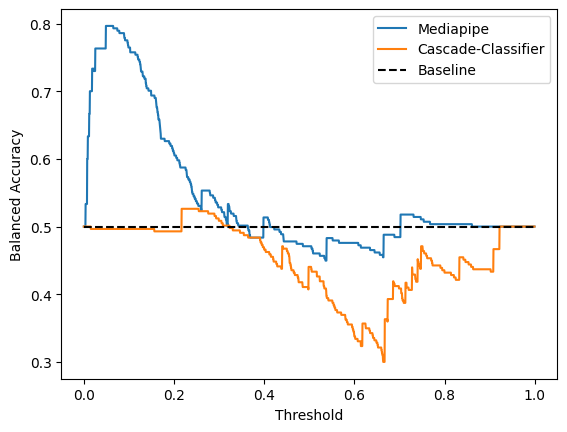

In [43]:
baccs1 = []
baccs2 = []
thresholds = [i for i in np.arange(0,1,.0005)]
for threshold in thresholds:
    baccs1.append(balanced_accuracy_score(compare3_dropna.annotated, [int(x>threshold) for x in compare3_dropna.mediapipe_score]))

for threshold in thresholds:
    baccs2.append(balanced_accuracy_score(compare3_dropna.annotated, [int(x>threshold) for x in compare3_dropna.cascade_score]))


plt.plot(thresholds, baccs1, label = "Mediapipe")
plt.plot(thresholds, baccs2, label = "Cascade-Classifier")
plt.hlines(.5, 0,1, "k", linestyles="--", label = "Baseline")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.savefig("data/face_detector_models_comparison.jpg")

In [44]:
def plot_baccs(df_merged, label = None):
    baccs = []
    thresholds = [i for i in np.arange(0,1,.005)]
    for threshold in thresholds:
        baccs.append(balanced_accuracy_score(df_merged.annotated, [int(x>threshold) for x in df_merged.score]))

    plt.plot(thresholds, baccs, label = label)


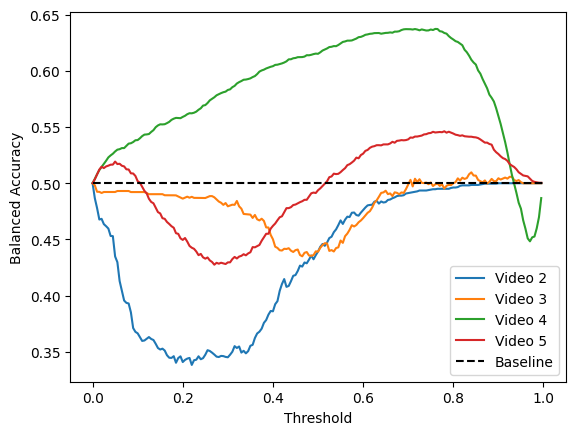

In [45]:
plot_baccs(merged2, "Video 2")
plot_baccs(merged3, "Video 3")
plot_baccs(merged4, "Video 4")
plot_baccs(merged5, "Video 5")
plt.hlines(.5, 0,1, "k", linestyles="--", label = "Baseline")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.savefig("data/video_threshold_comparison.jpg")